<a href="https://colab.research.google.com/github/aminrabinia/Covid_Sentiment_Analysis/blob/main/covid_tweets_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tweepy
import re
from textblob import TextBlob
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns


# Data Collection
(Needs secret key and token)

In [ ]:
import os
import tweepy as tw
import pandas as pd
from google.colab import files

consumer_key=''
consumer_secret=''                      
access_token_key=''
access_token_secret= ''

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
search_words='#covid'+ " -filter:retweets"
date_since='2020-06-5'

tweets = tw.Cursor(api.search, 
              tweet_mode='extended',
              q=search_words,
              lang="en",
              since=date_since).items(1000)

In [ ]:
mylist=[]

for tweet in tweets:
  mylist.append([tweet.created_at, tweet.user.location, tweet.user.screen_name,tweet.user.followers_count, tweet.favorite_count, tweet.retweet_count, tweet.full_text ])
print(mylist[-1])

In [ ]:
newdf=pd.DataFrame(mylist,columns=['data time','location','user','followers','text','likes','retweets'])
writer = pd.ExcelWriter('newTweets.xlsx')
newdf.to_excel(writer, 'newsheet' )
writer.save()
!dir

# Preprocessing the Data 


In [ ]:
covid_raw_data = pd.read_excel('/content/CovidTweets.xlsx')
df=pd.DataFrame(covid_raw_data)
df.head(5)

In [ ]:
def clean_tweet(text):
  text=text.lower()
  text = re.sub('@+', '', text)
  text = re.sub('\d+', '', text)
  text = re.sub('#', '', text) 
  text = re.sub('\n', '', text)
  text = re.sub('RT[\s]+', '', text)
  text = re.sub('https?:\/\/\S+', '', text) 
  return text

def sentiment_polarity(text):
  return TextBlob(text).sentiment.polarity

df['text']=df['text'].apply(clean_tweet)

df['sentiment']=df['text'].apply(sentiment_polarity)

In [ ]:
# few samples of automated labeling with high polarity
for i in range (len(df['text'])):
  if df['sentiment'][i]>0.7 or df['sentiment'][i]< -0.7:
    print("%.1f" %df['sentiment'][i], df['text'][i])

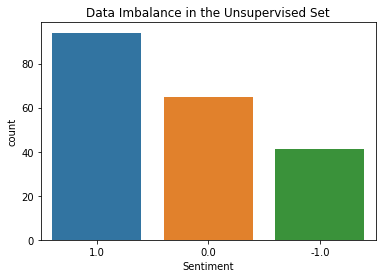

In [ ]:
def data_categorical(value):
  if value>0: return 1
  elif value<0: return -1
  else: return 0

df_copy=df
df_copy['sentiment']= df_copy['sentiment'].apply(data_categorical)[:200]

sns.countplot(
  x='sentiment',
  data=df_copy,
  order=df.sentiment.value_counts().index
)

plt.xlabel("Sentiment")
plt.title("Data Imbalance in the Unsupervised Set");

In [ ]:
writer = pd.ExcelWriter('LabeledTweets.xlsx')
df.to_excel(writer, 'newsheet' )
writer.save()

# Data Split and Vectorize

In [ ]:
labeled_data = pd.read_excel('LabeledTweets.xlsx') # labels manually corrected
df = pd.DataFrame(labeled_data)

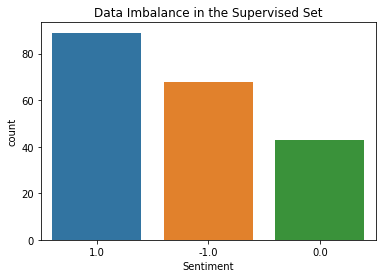

In [ ]:
def data_categorical(value):
  if value>0: return 1
  elif value<0: return -1
  else: return 0

DATA_CUT = 200 
df_copy=df
df_copy['sentiment']= df_copy['sentiment'].apply(data_categorical)[:DATA_CUT]

sns.countplot(
  x='sentiment',
  data=df_copy,
  order=df.sentiment.value_counts().index
)

plt.xlabel("Sentiment")
plt.title("Data Imbalance in the Supervised Set");

In [ ]:
X = df['text'][:DATA_CUT]
y = df['sentiment'][:DATA_CUT]

label = []

for x in y:
  if x>0: label.append(1)
  else: label.append(0)

X_train, X_test, y_train, y_test = train_test_split(X, label, 
                                      test_size=0.30, random_state=42)

print('Train size: %d' %len(y_train))
print('Test size:  %d' %len(y_test))

Train size: 140
Test size:  60


In [ ]:
vectorizer = TfidfVectorizer(min_df = 1,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Classifiers

SVM

positive:  {'precision': 0.9333333333333333, 'recall': 0.4827586206896552, 'f1-score': 0.6363636363636364, 'support': 29}
negative:  {'precision': 0.6666666666666666, 'recall': 0.967741935483871, 'f1-score': 0.7894736842105263, 'support': 31}


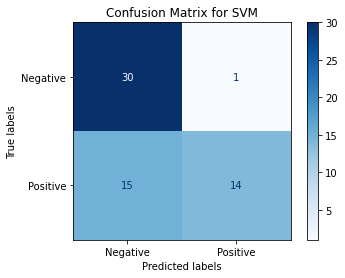

In [ ]:
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(X_train_vectors, y_train)

prediction_linear = classifier_linear.predict(X_test_vectors)

report = classification_report(y_test, prediction_linear, output_dict=True)
print('positive: ', report['1'])
print('negative: ', report['0'])

class_names = ['Negative','Positive']
plot_confusion_matrix(classifier_linear, X_test_vectors, y_test,display_labels=class_names,
                      cmap=plt.cm.Blues,
                      normalize=None)
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
#plt.show()
plt.savefig('cm for SVM')


KNN


KNN results
              precision    recall  f1-score   support

           0       0.58      0.84      0.68        31
           1       0.67      0.34      0.45        29

    accuracy                           0.60        60
   macro avg       0.62      0.59      0.57        60
weighted avg       0.62      0.60      0.57        60



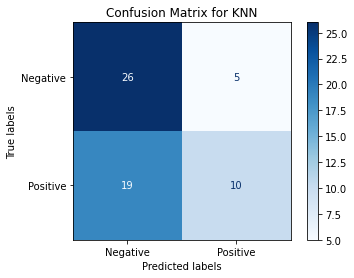

In [ ]:
'''KNN'''
knnModel = KNeighborsClassifier(n_neighbors=9).fit(X_train_vectors, y_train)
prediction_knn = knnModel.predict(X_test_vectors)
report_knn = classification_report(y_test, prediction_knn)
plot_confusion_matrix(knnModel, X_test_vectors, y_test,display_labels=class_names,
                      cmap=plt.cm.Blues,
                      normalize=None)
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
#plt.show()
plt.savefig('cm for KNN')
print('\nKNN results')
print(report_knn)
#print('\npositive: ', report_knn['0'])
#print('negative: ', report_knn['1'])

Random Forrest


Decision tree results
              precision    recall  f1-score   support

           0       0.54      0.94      0.68        31
           1       0.67      0.14      0.23        29

    accuracy                           0.55        60
   macro avg       0.60      0.54      0.46        60
weighted avg       0.60      0.55      0.46        60



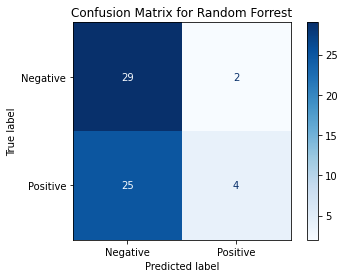

In [ ]:
'''Random Forrest'''
rf_model = RandomForestClassifier(max_depth=11, random_state=0).fit(X_train_vectors, y_train)
prediction_rf = rf_model.predict(X_test_vectors)
report_rf = classification_report(y_test, prediction_rf)
plot_confusion_matrix(rf_model, X_test_vectors, y_test,display_labels=class_names,
                      cmap=plt.cm.Blues,
                      normalize=None)
plt.title('Confusion Matrix for Random Forrest')
plt.xlabel('Predicted label')
plt.ylabel('True label')
#plt.show()
plt.savefig('cm for Random Forrest')
print('\nRandom Forest results')
print(report_rf)